In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
from scipy.optimize import curve_fit
from numpy.fft import ifft2, fft2, fftshift, ifftshift

import matplotlib.style as style
# Use your custom style
style.use('/Users/crc/Dropbox (MIT)/scientific_custom.mplstyle')

# Set the font properties directly in the script
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
value = 20
plt.rcParams['font.size'] = value
plt.rcParams['axes.labelsize'] = value
plt.rcParams['axes.titlesize'] = value
plt.rcParams['xtick.labelsize'] = value
plt.rcParams['ytick.labelsize'] = value
plt.rcParams['legend.fontsize'] = value

In [4]:
# == == == ==
# Functions to load and plot AFM images.
# == == == ==

def load_afm_image(zeroData=True):
    """ Load an AFM image with X, Y, and Z coordinates. """
    filename = input('Enter the name of the AFM image: ')
    data_txt = np.genfromtxt(filename + '.txt')
    data_xyz = np.genfromtxt(filename + '.xyz')
    Z = data_txt/1e-6 # Z in units of microns.
    if zeroData:
        Z = Z - np.min(Z)
    image_shape = np.shape(data_txt)
    X = data_xyz[:,0].reshape(image_shape)/1e-6 # X in units of microns.
    Y = data_xyz[:,1].reshape(image_shape)/1e-6 # Y in units of microns.
    return X, Y, Z, filename


def show_afm_image(X=None, Y=None, Z=None):
    """ Plot an AFM image that was loaded using load_afm_image(). """
    if X is None or Y is None or Z is None:
        print('Function input is empty! Load an AFM image!')
        X, Y, Z = load_afm_image()
    plt.pcolormesh(X, Y, Z)
    plt.colorbar()
    plt.set_cmap('Greys_r')
    plt.xlabel('X [microns]')
    plt.ylabel('Y [microns]')
    return X, Y, Z

In [5]:
# == == == ==
# Functions to fit and process the data.
# == == == ==

def fourier_series(x, y, coeffs):
    """ Compute 2D Fourier series up to specified order using vectorized operations. """
    nx, ny = x.shape
    order = int(np.sqrt(len(coeffs) / 4))
    Z = np.zeros((nx, ny))
    idx = 0
    period = coeffs[-1]

    x_indices = np.arange(nx).reshape(nx, 1)
    y_indices = np.arange(ny).reshape(1, ny)

    for kx in range(order):
        for ky in range(order):
            A = coeffs[4 * idx]
            B = coeffs[4 * idx + 1]
            C = coeffs[4 * idx + 2]
            D = coeffs[4 * idx + 3]

            cos_kx_x = np.cos(2 * np.pi * kx * x_indices / period)
            sin_kx_x = np.sin(2 * np.pi * kx * x_indices / period)
            cos_ky_y = np.cos(2 * np.pi * ky * y_indices / period)
            sin_ky_y = np.sin(2 * np.pi * ky * y_indices / period)

            Z += (A * cos_kx_x * cos_ky_y +
                  B * cos_kx_x * sin_ky_y +
                  C * sin_kx_x * cos_ky_y +
                  D * sin_kx_x * sin_ky_y)
            idx += 1

    return Z.ravel()


def rms(Z):
    zbar = np.mean(Z)
    sigma = np.sqrt(np.sum((Z - zbar)**2)/np.size(Z))
    return sigma


def autocov(Z):
    """ Calculate the autocovariance using the autocorrelation
        and the variance. """
    var = np.var(Z)
    C = correlate2d(Z, Z, boundary='wrap')
    return C*var # important to multiply by var 


def wienerkhinchin(Z):
    """ Calculate the autocovariance using the power spectral density
        (via the Wiener-Khinchin theorem). This is more  of a sanity check. """
    var = np.var(Z)
    z = fftshift(fft2(Z))
    PSD = np.abs(z)**2
    C = ifft2(ifftshift(PSD))
    return C*var


def hprobdist(Z, bins):
    """ Calculate the height probability distribution. """
    H = np.histogram(Z)
    P, h = np.histogram(Z, bins=bins, density=True)
    p = P / np.sum(P)
    return p, h


def plotph(p, h):
    """ Plot the height probability distribution. """
    plt.plot(h[0:-1], p)
    plt.xlabel('h [microns]')
    plt.ylabel('p(h)')
    
def extract_periodic_components(Z, keep_fraction=0.1):
    """
    Extracts the largest Fourier components of Z.
    
    Parameters:
    - Z: 2D array of shape (m, n), the data map with periodic components and noise.
    - keep_fraction: float, the fraction of the largest Fourier amplitudes to keep.
    
    Returns:
    - Z_approx: 2D array of shape (m, n), the approximation of Z with primary periodic components.
    """
    # Compute the 2D FFT
    Z_fft = np.fft.fft2(Z)
    # Compute magnitudes
    magnitudes = np.abs(Z_fft)
    
    # Create a threshold to zero out small components
    threshold = np.sort(magnitudes.ravel())[-int(keep_fraction * magnitudes.size)]
    
    # Zero out small Fourier components
    Z_fft[magnitudes < threshold] = 0
    
    # Compute the inverse FFT
    Z_approx = np.fft.ifft2(Z_fft).real
    
    return Z_approx

Enter the name of the AFM image:  Large_Scale_S1_0002


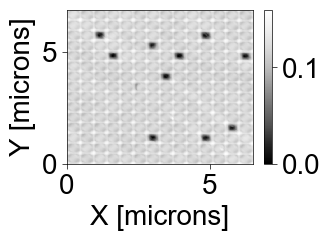

In [6]:
# """ Loading an AFM image. """
X, Y, Z, filename = load_afm_image()
x = X.flatten()
y = Y.flatten()
z = Z.flatten()
period = 0.445 # Units of microns. Change value as appropriate, but it needs to be in microns.
#Large_Scale_S1_0002 (Fig. 4c)
#Large_Scale_S2_0002 (Fig. 4d)
show_afm_image(X, Y, Z);

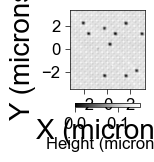

In [9]:
# Assuming X and Y are 1D arrays representing the coordinates
x_min, x_max = X.min(), X.max()
y_min, y_max = Y.min(), Y.max()
x_mean = np.mean([x_min, x_max])
y_mean = np.mean([y_min, y_max])

fig, ax = plt.subplots(figsize=(2, 2))
cmap = 'Greys_r'  # Change the colormap to whatever you like.

# Set the extent using the min and max of X and Y
extent = [x_min-x_mean, x_max-x_mean, y_min-y_mean, y_max-y_mean]

im1 = ax.imshow(Z, cmap=cmap, origin='lower', extent=extent, vmin=0, vmax=0.15)
# Adjust the x-ticks to only show -3, 0, 3
# ax.set_xticks([-3, 0, 3])
# ax.set_yticks([-3, 0, 3])
ax.set_xticks([-2, 0, 2])
ax.set_yticks([-2, 0, 2])

# Adjust the colorbar length
cbar1 = fig.colorbar(im1, ax=ax, orientation='horizontal', pad=0.15, fraction=0.05, shrink=0.5)
cbar1.set_label('Height (microns)', fontsize=12)

# Adjust font sizes for tick labels
ax.tick_params(axis='both', which='major', labelsize=12)
cbar1.ax.tick_params(labelsize=12)

plt.tight_layout()

plt.xlabel('X (microns)')
plt.ylabel('Y (microns)')

plt.savefig('{0}-original-afm-image.svg'.format(filename))
plt.show()


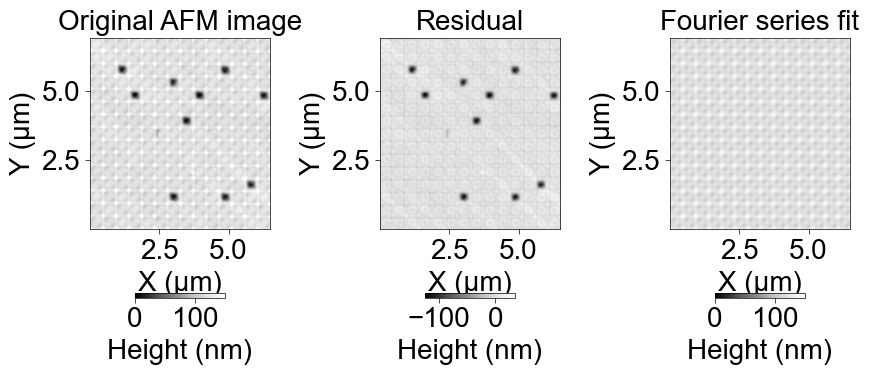

In [10]:
# Extract largest Fourier components and returns filtered map
# Z_approx = extract_periodic_components(Z, keep_fraction=0.0005) # for sample 2
Z_approx = extract_periodic_components(Z, keep_fraction=0.0001) # for sample 1
r_approx = Z - Z_approx

# Plot the results.
fig, ax = plt.subplots(1, 3, figsize=(9, 5))
cmap = 'Greys_r' # Change the colormap to whatever you like.

im1 = ax[0].imshow(Z*1e3, cmap=cmap, origin='lower', extent=(x_min, x_max, y_min, y_max), vmin=0, vmax=0.15*1e3)
ax[0].set_title('Original AFM image')
ax[0].set_xlabel('X (μm)')
ax[0].set_ylabel('Y (μm)')
cbar1 = fig.colorbar(im1, ax=ax[0], orientation='horizontal', shrink = 0.5, pad=0.15)
cbar1.set_label('Height (nm)')

im2 = ax[1].imshow(r_approx*1e3, cmap=cmap, origin='lower', extent=(x_min, x_max, y_min, y_max))
ax[1].set_title('Residual')
ax[1].set_xlabel('X (μm)')
ax[1].set_ylabel('Y (μm)')
cbar2 = fig.colorbar(im2, ax=ax[1], orientation='horizontal', shrink = 0.5, pad=0.15)
cbar2.set_label('Height (nm)')

im3 = ax[2].imshow(Z_approx*1e3, cmap=cmap, origin='lower', extent=(x_min, x_max, y_min, y_max), vmin=0, vmax=0.15*1e3)
ax[2].set_title('Fourier series fit')
ax[2].set_xlabel('X (μm)')
ax[2].set_ylabel('Y (μm)')
cbar3 = fig.colorbar(im3, ax=ax[2], orientation='horizontal', shrink = 0.5, pad=0.15)
cbar3.set_label('Height (nm)')

plt.tight_layout()
plt.savefig('all-maps-{0}.svg'.format(filename))
plt.show()

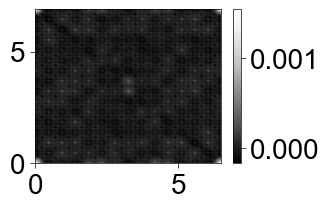

In [11]:
""" Sanity check. """

# # Autocorrelation times variance.
# C_direct = autocov(r)
# # Trim the array; because of the boundary conditions, there are four copies of the autocovariance.
# (nx, ny) = np.shape(r)
# C_direct = C_direct[0:nx,0:ny]
# # Plot result.
# plt.figure()
# plt.pcolormesh(X, Y, C_direct)
# plt.colorbar()

# Wiener-Khinchin theorem.
C_wk = wienerkhinchin(r_approx)
# Plot result. It should agree with the previous result.
plt.figure()
plt.pcolormesh(X, Y, np.real(C_wk)) # There is a negligibly small (on the order of 1e-15) imaginary part.
plt.colorbar()

""" Since these agree with each other, you can compute the autocovariance
    using the Wiener-Khinchin theorem, which will save time. """

C = C_wk

μ_rms = -2.1362977104725905e-14 nm
σ_rms = 10.713947584324437 nm


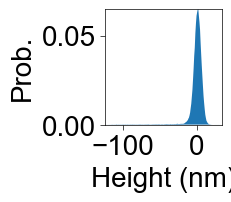

In [12]:
# Height probability distribution.
# r = Z - Z_fit
r_approx = (Z-Z_approx)*1e3
# mask = np.abs(r_approx) <= 50
# r_approx = r_approx[mask]

p, h = hprobdist(r_approx, 200)
h = h[0:-1]

plt.figure(figsize = (1.5,1.5))
plt.fill_between(h, p)
plt.xlabel('Height (nm)')
plt.ylabel('Prob.')
# plt.xlim([-50,50])

# RMS roughness.
# sigma_rms = rms(r) 
mu_rms = np.mean(r_approx)
sigma_rms = rms(r_approx)
# sigma_rms = np.std(r_approx)
print("μ_rms = {0} nm".format(mu_rms))
print("σ_rms = {0} nm".format(sigma_rms))

plt.savefig('probs-{0}.svg'.format(filename))

In [13]:
# Save data.
data = {"X":X, "Y":Y, "period":period, "Z":Z, "Z_fit":Z_approx,
        "autocovariance":C, "RMS_roughness":sigma_rms, "height_probability_distribution":p, "height_bins":h}
np.save(filename + "_processed", data, allow_pickle = True)

In [14]:
import numpy as np
from scipy.optimize import curve_fit

# Define the Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit to a Gaussian and calculate sigma and FWHM
def fit_gaussian(x, y):
    # Guess initial parameters: amplitude (A), mean (mu), and sigma (standard deviation)
    A_guess = max(y)
    mu_guess = x[np.argmax(y)]
    sigma_guess = np.std(x)
    
    # Perform the curve fit
    popt, pcov = curve_fit(gaussian, x, y, p0=[A_guess, mu_guess, sigma_guess])

    perr = np.sqrt(np.diag(pcov))  # Standard deviation errors on the parameters
    sigma_error = perr[2]  # Error on sigma (3rd parameter)
    
    # Extract fitted parameters
    A, mu, sigma = popt
    
    # Calculate FWHM (Full Width at Half Maximum)
    FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma
    
    # Print the results
    print(f"Sigma: {sigma}")
    print(f"Sigma_error: {sigma_error}")
    print(f"FWHM: {FWHM}")
    
    return sigma, sigma_error, FWHM, popt

In [15]:
# Example usage with x, y data
sigma, sigma_error, FWHM, popt = fit_gaussian(h, p)

Sigma: 4.725895415896897
Sigma_error: 0.012548806491014069
FWHM: 11.128633256073888


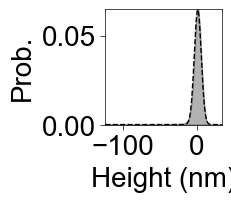

In [16]:
plt.figure(figsize = (1.5,1.5))
plt.fill_between(h, p, color = 'black', alpha = 0.3)
plt.plot(h, gaussian(h, *popt), '--', color = 'black')
plt.xlabel('Height (nm)')
plt.ylabel('Prob.')


plt.savefig('probs-with-fit-{0}.svg'.format(filename))